In [ ]:
import re

In [ ]:
from functools import cmp_to_key

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.9 MB/s eta 0:00:00


In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/Rajlaxmi2002/CRAFT.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt

import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

In [ ]:
pretrained_model = 'CRAFT/craft_mlt_25k.pth'

In [ ]:
download_dir = "/content/images"
!mkdir -p {download_dir} && rm -rf {download_dir}/*

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compare(a,b):
  y1=int((a[0]+a[1])/40)
  y2=int((b[0]+b[1])/40)
  x1=int((a[2]+a[3])/40)
  x2=int((b[2]+b[3])/40)
  if(y1>y2):return 1
  elif(y1<y2):return -1
  if(x1>x2):return 1
  elif(x1<x2):return -1
  return 0




In [ ]:
def compare2(a,b):
  if(a[1]>b[1]):
    return 1
  elif(a[1]<b[1]):
    return -1
  if(a[0]>b[0]):
    return 1
  elif(a[0]<b[0]):
    return -1
  return 0



In [ ]:
def segmentation(image):

  original = image.copy()
  gray = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
  detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
  cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  x=np.asarray(image)
  cnts2=cnts


  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
  detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
  cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  x=np.asarray(image)

  for c in cnts:
      cv2.drawContours(x, [c], -1, (255,255,255), 2)
  for c in cnts2:
      cv2.drawContours(x, [c], -1, (255,255,255), 2)
  new_img=x
  gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # Dilate with horizontal kernel
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,10))
  dilate = cv2.dilate(thresh, kernel, iterations=3)


  # Find contours and remove non-diagram contours
  cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  i=len(cnts)
  images=[]
  nimages=[]
  tem=[]
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    tem.append([x,y,w,h])
  cnts=tem
  cnts=sorted(cnts,key=cmp_to_key(compare2))
  for c in cnts:
      x,y,w,h = c
      area = w*h
      temp = np.asarray(original)[y:y+h, x:x+w]
      if  area > 20000:
          # cv2.drawContours(dilate, [c], -1, (0,0,0), -1)
          temp = np.asarray(original)[y:y+h, x:x+w]
          images.append(temp)
          temp = new_img[y:y+h, x:x+w]
          nimages.append(temp)
  image=original
  return images,nimages

In [ ]:
def ocr(i):
  image = Image.fromarray(i)

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_text

In [ ]:
def getlines2(image):

  original = image.copy()
  gray = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
  detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
  cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  x=np.asarray(image)
  se={0}
  for x in cnts:
    #print(x[0][1])
    se.add(x[0][0][1])
  se=list(se)
  se.sort()
  l=0
  imag=[]
  image=original
  for i in se[1:]:
    if(i-l>=15):
      nim=image[max(0,l-5):min(i+10,len(image))]
      # cv2_imshow(nim)
      imag.append(nim)

    l=i

  return imag

In [ ]:
def images_to_segments(images1):
  download_dir = "/content/images"
  !mkdir -p {download_dir} && rm -rf {download_dir}/*
  page_number=0
  n=len(images1)

  data={}
  images=[]
  for i in range(0,n):
    page=images1[i]
    # print(page_number)
    im,x=segmentation(page)
    seg=1
    for x in im:
      im_path="p"+str(page_number)+"s"+str(seg)
      images.append([page_number,seg,im_path])
      cv2.imwrite("/content/images/"+im_path+".jpg",x)
      seg=seg+1
    data[page_number]={"diagrams":[],"text":[]}
    page_number=page_number+1


  return data,images

In [ ]:
def segment_to_dict(data,images):
  !cd {project_name} && python test.py --trained_model=../{pretrained_model} --test_folder=/content/images
  answers={}
  ques=1
  answers[ques]={"text":[],"diagrams":[]}
  for x in images:
    prev=""
    img=cv2.imread("/content/images/"+x[2]+".jpg")
    f = open("/content/CRAFT/result/res_"+x[2]+".txt", "r")
    mylist=[]
    yx={}
    ylist=[]
    sum=0
    for s in f:
      a,b,c,_,_,d,_,_=s.split(",")
      b=int(b)
      d=int(d)
      a=int(a)
      c=int(c)
      sum=sum+(d-b)*(c-a)
      height, width, _ = img.shape
      b=max(0,b-2)
      a=max(0,a-2)
      d=min(height,d+2)
      c=min(width,c+2)
      mylist.append([b,d,a,c])
      temp=int((b+d)/2)
      temp1=int((b+d)/2+(d-b)/4)
      temp2=int((b+d)/2-(d-b)/4)
      if temp in yx.keys():
        yx[temp][0]=min(a,yx[temp][0])
        yx[temp][1]=max(c,yx[temp][1])
      else:
        yx[temp]=[a,c]
      ylist.append(temp)
      if temp1 in yx.keys():
        yx[temp1][0]=min(a,yx[temp][0])
        yx[temp1][1]=max(c,yx[temp][1])
      else:
        yx[temp1]=[a,c]

      if temp2 in yx.keys():
        yx[temp2][0]=min(a,yx[temp][0])
        yx[temp2][1]=max(c,yx[temp][1])
      else:
        yx[temp2]=[a,c]

    f.close()
    ylist.sort()
    mylist=sorted(mylist, key=cmp_to_key(compare))
    ct=""
    height, width, _ = img.shape
    prev=0
    for tx in ylist:

      if(tx-prev<=40):
        continue
      prev=tx
      y1,y2=tx-25,tx+30
      y1=int(max(0,y1))
      y2=int(min(y2,height))
      x1=yx[tx][0]
      x2=yx[tx][1]
      for temp in range(y1,y2+1):
        if(temp in yx.keys()):
          # print("please work",yx[temp])
          x1=min(x1,yx[temp][0])
          x2=max(x2,yx[temp][1])
      #print(y1,y2,x1,x2)
      line=img[y1:y2,x1:x2]
      text=ocr(line)
      text=text.replace(".","")
      text=text.replace("#","")
      text=text.replace("'","")
      text=text.replace("(","")
      if text.find("Answer")!=-1:
        ques=ques+1
        answers[ques]={"text":[],"diagrams":[]}
      text=text.replace("Answer","")
      ct=ct+" "+text
      #cv2_imshow(img[y1:y2])
      #cv2_imshow(line)
      #print(text)
    height, width, _ = img.shape
    total=height*width
    #print("text: ",ct)
    #print("ratio: ",sum/total)
    if(sum/total>=0.07):
      # ct=ct.strip()
      # ct=ct[max(0,ct.find(" "))]
      data[x[0]]["text"].append(ct)
      answers[ques]["text"].append(ct)
    elif(sum/total>0.01):
      data[x[0]]["diagrams"].append(img)
      answers[ques]["diagrams"].append(img)
  for x in answers:
    answers[x]['text'][0]=answers[x]['text'][0].strip()

  return data,answers

In [ ]:
im2=cv2.imread("/content/c2.jpeg")
im3=cv2.imread("/content/c3.jpeg")
im4=cv2.imread("/content/d4.jpeg")
im5=cv2.imread("/content/d5.jpeg")
images1=[im2,im3,im4,im5]
data,images=images_to_segments(images1)
data,answers=segment_to_dict(data,images)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Loading weights from checkpoint (../CRAFT/craft_mlt_25k.pth)
elapsed time : 29.9947030544281s


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  ) -> Tuple[GenerationConfig, Dict]:


[' Binary Search is an efficient algorithm for finding " a target value Within a sorted! array " It works by repeatedly dividing the search space in half if the value of the target element " is less than " the middle element of " the interval : the algorithm marrows the interval to lower " half If the target value is greater, it marriages it to the upper half This " process continues until target valite is reached or if interval is empty advantages efficiency Binary search has a time complexity of log n ) which means it can quickly find the target value in large " dataset! reduces number of comparisons Binary search requires " maximum log m ) compositions which is much smaller compared to other search algorithms Applicability with various data structures versatile data structure that can be adapted for various data types', ' Disadvantages :, Requires sorted data : If " data is not sorted, this is an Traditional overheard when data is not spotted to the Not suitable for dynamic data', '

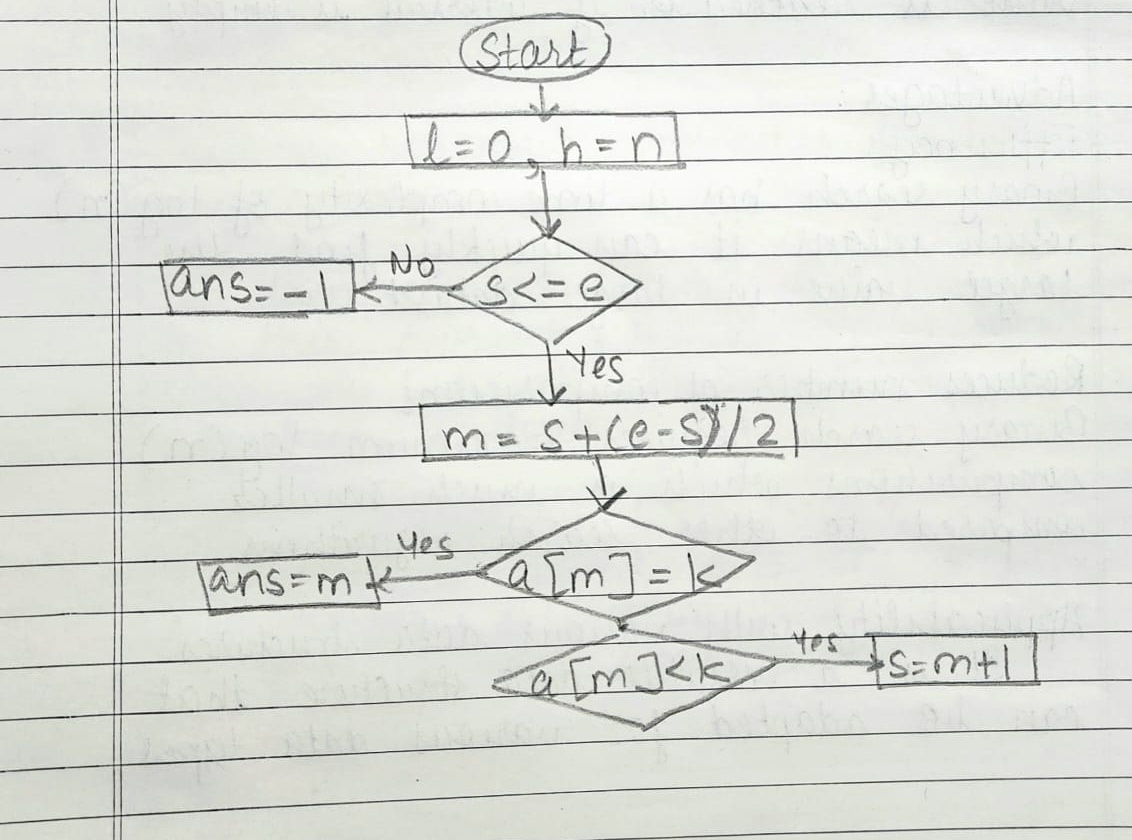

[' Dynamic programming is a method for solving complex by breaking them down into simplex subiprollers', ' The key principle of dynamic programming the satire each problem only " I once and store its solution for future reference This is tension principle " of optimality which states that an " optimal " " solution for a problem contains optional solution to its subproblem']
[' There are two main approaches for dynamic programming', ' Top down approach  Memorization ) In this research the problem is solved reversively but with " this result of subproblem is stored', ' Bottom up approach  Tabulation ) subproblem " is solved iteratively starting from simplett subproblem and gradually building up to a larger']
['  Advantages of homo over stroke', ' Dynamic Memory Allocation - Heaps allow for dynamic memory allocation, which means you that needs " to grow or shrink in size! Variable lifetime " Objects allocated on the heap have a variable " Lifetime, meaning they can exist beyond the scape 

In [ ]:
for x in answers:
  text=answers[x]["text"]
  text[0]=text[0][text[0].find(" "):]
  print(text)

  for j in answers[x]["diagrams"]:
    cv2_imshow(j)

In [ ]:
!pip3 install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
!pip3 install ctransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.9 MB/s eta 0:00:00


In [ ]:
import langchain
from langchain.llms import CTransformers

In [ ]:
llm = CTransformers(model='TheBloke/Mistral-7B-Instruct-v0.1-GGUF', model_file='mistral-7b-instruct-v0.1.Q6_K.gguf', config={'gpu_layers':100,'context_length':1000})

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.1.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
from langchain import PromptTemplate, LLMChain

In [ ]:
prompt_template = PromptTemplate.from_template(
        """
        <s> [INST] You will be provided with a model answer text and an input answer. You need to judge the input answer by evaluating it against the model answer on parameters like important points covered, grammatical correctness, and sentence structure. Based on all these factors you need to generate a result of the final score that can be asssigned to the input answer out of 5.

        Model answer: {answer}
        Input answer: {input}

        Return just the final score and nothing else no extra accompanying characters.

        [/INST]
        """
    )
chain = LLMChain(prompt=prompt_template, llm=llm)

In [ ]:
model_answers = [
    "Binary search is an efficient algorithm for finding a target value within a sorted array. It works by repeatedly dividing the search interval in half. If the value of the target element is less than the middle element of the interval, the algorithm narrows the interval to the lower half. If the target value is greater, it narrows it to the upper half. This process continues until the target value is found or the interval is empty. Binary search offers several advantages over other search algorithms, particularly when searching through large sorted datasets: Efficiency: Binary search has a time complexity of O(log n), which means it can quickly find the target element in large datasets. This efficiency is crucial for applications that require fast searching, such as databases and sorting algorithms. Simplicity: The binary search algorithm is relatively simple to implement and understand. It follows a clear and logical process of dividing the search interval in half until the target element is found or the interval is empty. Requires Sorted Data: While requiring the data to be sorted may seem like a limitation, it is also an advantage in certain contexts. If the data is already sorted, binary search can be used directly without the need for additional preprocessing steps. Reduced Number of Comparisons: Binary search reduces the number of comparisons needed to find the target element compared to linear search algorithms. In a dataset with n elements, binary search typically requires log2(n) comparisons, which is much smaller than n in most practical cases. Applicability to Various Data Structures: Although commonly used with arrays, binary search can be adapted to work with other data structures such as trees and graphs, providing a versatile search algorithm for different types of data. Binary search, despite its efficiency and simplicity, has several limitations and disadvantages: Requires Sorted Data: As mentioned earlier, binary search requires the input data to be sorted. If the data is not sorted, binary search cannot be applied directly, and sorting the data adds an additional overhead. Not Suitable for Dynamic Data: Binary search is not suitable for dynamic data structures where elements are frequently inserted or deleted. Maintaining a sorted order in such structures can be challenging and may negate the benefits of binary search. Memory Overhead: While the algorithm itself does not require much additional memory, the need to maintain a sorted array or data structure can lead to increased memory usage, especially for large datasets. Complexity of Implementation for Some Data Structures: While binary search is straightforward to implement for arrays, it can be more complex for other data structures such as trees or graphs. In these cases, additional logic is required to adapt the algorithm to work with the specific data structure. Potential for Bugs: Incorrectly implementing the binary search algorithm can lead to bugs, especially in edge cases or when dealing with boundary conditions. Careful attention is needed to ensure the algorithm behaves correctly in all scenarios. Limited Applicability: Binary search is most effective for searching in sorted arrays or structures where random access is possible. It may not be suitable for all types of data or structures, limiting its applicability in certain scenarios.",
    ".Dynamic programming (DP) is a method for solving complex problems by breaking them down into simpler subproblems. It involves solving each subproblem only once and storing its solution in a table (usually an array or matrix). This approach avoids redundant calculations and leads to more efficient solutions. The key principle of dynamic programming is to solve each subproblem only once and store its solution for future reference. This is known as the principle of optimality, which states that an optimal solution to a problem contains optimal solutions to its subproblems.",
    "There are two main approaches to dynamic programming: Top-down approach (Memoization): In this approach, the problem is solved recursively, but with the addition of a memory mechanism (memoization) to store the results of subproblems. This avoids redundant calculations by checking if a subproblem has already been solved before solving it again. Bottom-up approach (Tabulation): In this approach, the problem is solved iteratively, starting from the simplest subproblems and gradually building up to the larger problem. The results of subproblems are stored in a table, and the final solution is computed based on these results.",
    "Heaps and stacks are both data structures used in computer science, but they serve different purposes and have different advantages. Here are some advantages of a heap over a stack: Dynamic Memory Allocation: Heaps allow for dynamic memory allocation, which means you can allocate memory as needed during program execution. This is useful for storing data structures that need to grow or shrink in size, such as arrays or linked lists. Variable Lifetime: Objects allocated on the heap have a variable lifetime, meaning they can exist beyond the scope of the function that created them. This allows you to create objects that persist even after the function has returned. Efficient Memory Management: Heaps use more sophisticated memory management techniques, such as memory pooling and garbage collection, which can lead to more efficient memory usage compared to stacks. Large Memory Allocation: Heaps can allocate larger amounts of memory than stacks, which are typically limited in size. Flexibility: Heaps offer more flexibility in terms of memory management, allowing you to allocate and deallocate memory in a more dynamic and controlled manner. Overall, the heap is useful for managing memory that needs to be dynamically allocated and deallocated, while the stack is more suitable for managing function call execution and local variable storage."
]

In [ ]:
for x in answers:
  text=answers[x]["text"]
  text[0]=text[0][text[0].find(" "):]
  print(text)

  # for j in answers[x]["diagrams"]:
  #   cv2_imshow(j)

  input_text = model_answers[x-1]
  print(input_text)

  print("marks")
  print(chain.run(answer=text[0], input=input_text))


[' Binary Search is an efficient algorithm for finding " a target value Within a sorted! array " It works by repeatedly dividing the search space in half if the value of the target element " is less than " the middle element of " the interval : the algorithm marrows the interval to lower " half If the target value is greater, it marriages it to the upper half This " process continues until target valite is reached or if interval is empty advantages efficiency Binary search has a time complexity of log n ) which means it can quickly find the target value in large " dataset! reduces number of comparisons Binary search requires " maximum log m ) compositions which is much smaller compared to other search algorithms Applicability with various data structures versatile data structure that can be adapted for various data types', ' Disadvantages :, Requires sorted data : If " data is not sorted, this is an Traditional overheard when data is not spotted to the Not suitable for dynamic data', '

Object Detection

In [ ]:
"""Classes -> Block and Text"""

import json

from Enums import LABEL
from Classes.Text import Text


class Block:
    """This class handles the blocks on pictures"""
    id:  int
    object_type: LABEL
    x_min: float
    x_max: float
    y_min: float
    y_max: float
    confidence: float
    Texts: [Text] = []
    Next_Blocks: [int] = []
    Previous_Blocks: [int] = []
    Next_Blocks_Conditionals: {int, str} = {}

    def __init__(self, id, x_min, y_min, x_max, y_max, confidence, name):
        self.id = id
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.confidence = confidence

        for entry in LABEL:
            if entry.name == name:
                self.object_type = entry

    def sort_text(self) -> None:
        if len(self.Texts) > 0:
            self.Texts.sort(key=lambda x: x.x_min)
            id: int = self.Texts[0].id
            x_min: float = self.Texts[0].x_min
            y_min: float = self.Texts[0].y_min
            x_max: float = self.Texts[len(self.Texts) - 1].x_max
            y_max: float = self.Texts[len(self.Texts) - 1].y_max
            confidence: float = sum(x.confidence for x in self.Texts) / len(self.Texts)
            txt: str = ""
            for t in self.Texts:
                txt += "{} ".format(t.text)
            text: Text = Text(id, x_min, y_min, x_max, y_max, confidence, txt)
            self.Texts.clear()
            self.Texts.append(text)

    def to_string(self) -> str:
        string: str = "id: {}, object_type: {}, x_min: {}, x_max: {}, y_min: {}, y_max: {}, confidence: {}\n".format(
            self.id, self.object_type, self.x_min, self.x_max, self.y_max, self.y_min, self.confidence)

        string += "next blocks count: {}\n".format(len(self.Next_Blocks))
        neighbour: int
        for i, neighbour in enumerate(self.Next_Blocks):
            string += "-Neighbour {}: {}\n".format(i, neighbour)

        string += "previous blocks count: {}\n".format(len(self.Previous_Blocks))
        neighbour: int
        for i, neighbour in enumerate(self.Previous_Blocks):
            string += "-Neighbour {}: {}\n".format(i, neighbour)

        if "decision" in self.object_type.name:
            string += "Conditional next neigbours: {}\n".format(len(self.Next_Blocks_Conditionals))
            string += json.dumps(self.Next_Blocks_Conditionals)
            string += "\n"

        string += "Inner texts: {}\n".format(len(self.Texts))
        for text in self.Texts:
            string += "{}\n".format(text.confidence)
            string += "{}\n".format(text.text)

        return string



class Text:
    """This class handles texts"""
    id: int
    x_min: float
    x_max: float
    y_min: float
    y_max: float
    confidence: float
    text: str

    def __init__(self, id, x_min, y_min, x_max, y_max, confidence, text):
        self.id = id
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.confidence = confidence
        self.text = text

    def to_string(self) -> str:
        string: str = "id: {}, x_min: {}, x_max: {}, y_min: {}, y_max: {}, confidence: {}, text: {}\n".format(
            self.id, self.x_min, self.x_max, self.y_max, self.y_min, self.confidence, self.text)
        return string


In [ ]:
"""Constants"""
# Path to block detection model
block_detection_model = './best(L).pt'

# If any detection have less than this value, it will not be considered
CONFIDENCE_THRESHOLD = 0.4

# Value used to get double detections
DUPLICATE_THRESHOLD = 20

# Value used to limit arrow do-while loop
DO_WHILE_LOOPS = 10

# Value used to set block ID prefix
BLOCK_PREFIX = "Block"

# IMGBB URL
IMGBB_URL = "https://api.imgbb.com/1/upload"

# API key for upload images
IMGBB_API_KEY = "1f8cd84903460565f6153993e1247b14"

# Expiration time for uploaded images (in seconds)
IMGBB_EXPIRATION_TIME = 1800

# Azure OCR stuff
AZURE_OCR_SUBSCRIPTION_KEY = "2f2d917a42de4f9fb4e2fc39570ac927"                         
AZURE_OCR_ENDPOINT = "https://diagramocr.cognitiveservices.azure.com/"

# Folders
INPUT_FOLDER = r"\User_Files\InputImages"
OUTPUT_FOLDER = r"\User_Files\OutputFiles"

# Suffix to indicate variables
VAR_SUFFIX = "_var"

# Suffix to indicate functions
FUNC_SUFFIX = '_func'




In [ ]:
""" Enums """

from enum import Enum


class LABEL(Enum):
    start_end = 0
    scan = 1
    decision = 2
    print = 3
    process = 4
    arrow_line_up = 5
    arrow_line_down = 6
    arrow_line_right = 7
    arrow_line_left = 8
    pointer = 9


class OCR(Enum):
    AZURE = 1


mermaid_delete_characters: () = (
    '(',
    ')',
    '[',
    ']',
    '>',
    '{',
    '}',
    '/',
    '\\'
)

block_open: {} = {
    'start_end': '([',
    'scan': '[/',
    'decision': '{{',
    'print': '[\\',
    'process': '['
}

block_close: {} = {
    'start_end': '])',
    'scan': '/]',
    'decision': '}}',
    'print': '/]',
    'process': ']'
}

In [ ]:
"""ImgbbUploadFile"""

from PIL.Image import Image
from io import BytesIO
import Constants
import requests
import base64


def upload_image(img: Image) -> str:
    url: str = "{}?key={}&expiration={}".format(
        Constants.IMGBB_URL, Constants.IMGBB_API_KEY, str(Constants.IMGBB_EXPIRATION_TIME))
    im_file = BytesIO()
    img.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()
    im_b64 = base64.b64encode(im_bytes)
    files = {'image': im_b64}
    response = requests.post(url, files)
    response.raise_for_status()
    data = response.json()
    return data['data']['url']

In [ ]:
"""Easy OCR"""

import math
import sys
import easyocr
import numpy as np
import Debug
from PIL import Image
from Classes.Text import Text
from Classes.Block import Block


def get_text(img: Image, blocks: [Block]) -> [Block]:
    texts: [Text] = []
    reader = easyocr.Reader(['en'])
    image = np.array(img)
    results = reader.readtext(image)

    for i, res in enumerate(results):
        text: Text = Text(i, res[0][0][0], res[0][0][1], res[0][2][0], res[0][2][1], res[2], res[1])
        texts.append(text)

    temp: [[Block], [Text]] = __get_inner_texts(texts, blocks)
    blocks = __get_outer_text(temp[0], temp[1])

    return blocks


def __get_inner_texts(texts: [Text], blocks: [Block]) -> [[Block], [Text]]:
    inner_texts: [Text] = []
    block: Block

    for block in blocks:
        if "arrow" not in block.object_type.name:
            txt: [Text] = [x for x in texts if __is_text_inner(x, block)]
            block.Texts = txt
            for t in txt:
                inner_texts.append(t)
            block.sort_text()

    outer_texts: [Text] = texts
    for t in inner_texts:
        if t in outer_texts:
            outer_texts.remove(t)

    return [blocks, outer_texts]


def __get_outer_text(blocks: [Block], texts: [Text]) -> [Block]:
    text: Text
    for text in texts:
        block: Block = __get_conditional_arrow(text, blocks)
        block.Texts = [text]

    return blocks


def __is_text_inner(text: Text, block: Block) -> bool:
    center_x: float = (text.x_max + text.x_min) / 2
    center_y: float = (text.y_max + text.y_min) / 2
    return block.x_max > center_x > block.x_min and block.y_max > center_y > block.y_min


def __get_conditional_arrow(text: Text, blocks: [Block]) -> Block:
    center_text: (float, float) = (((text.x_max + text.x_min) / 2), ((text.y_max + text.y_min) / 2))
    block_points: [(float, float)] = [(float, float)]
    distances: {} = {}
    block: Block
    for block in blocks:
        if "arrow" in block.object_type.name:
            block_points.clear()
            block_points.append((block.x_max, block.y_max))
            block_points.append((block.x_max, block.y_min))
            block_points.append((block.x_min, block.y_max))
            block_points.append((block.x_min, block.y_min))
            block_points.append(((block.x_min + block.x_max) / 2, (block.y_min + block.y_max) / 2))

            distance: float = sys.float_info.max
            for point in block_points:
                if math.dist(point, center_text) < distance:
                    distance = math.dist(point, center_text)

            distances[block] = distance

    return min(distances.keys(), key=lambda k: distances[k])


In [ ]:
"""Azure OCR"""

import Constants
from ImgbbUploadFile import upload_image
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from Classes.Block import Block
from Classes.Text import Text
from OCR.EasyOCR import __get_inner_texts as get_inner_texts
from OCR.EasyOCR import __get_outer_text as get_outer_text
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential
from array import array
import os
from PIL import Image
import sys
import time


def AOCR(img: Image, blocks: [Block]) -> [Block]:

    subscription_key = Constants.AZURE_OCR_SUBSCRIPTION_KEY
    endpoint = Constants.AZURE_OCR_ENDPOINT
    
    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

    # Get an image with text
    read_image_url = upload_image(img)

    # Call API with URL and raw response (allows you to get the operation location)
    read_response = computervision_client.read(read_image_url,  raw=True)

    # Get the operation location (URL with an ID at the end) from the response
    read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    texts: [Text] = []
    # Print the detected text, line by line
    if read_result.status == OperationStatusCodes.succeeded:
        index: int = 0
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                x_min: float = line.bounding_box[0]
                y_min: float = line.bounding_box[1]
                x_max: float = line.bounding_box[4]
                y_max: float = line.bounding_box[5]
                text: Text = Text(index, line.bounding_box[0], line.bounding_box[1], line.bounding_box[4], line.bounding_box[5], line.words[0].confidence, line.text)
                index = index + 1
                texts.append(text)

    temp: [[Block], [Text]] = get_inner_texts(texts, blocks)
    blocks = get_outer_text(temp[0], temp[1])

    return blocks

In [ ]:
"""OCR"""

import Enums
from OCR import AzureOCR
from PIL import Image
from Classes.Text import Text
from Classes.Block import Block


def get_text(img: Image, blocks: [Block], ocr_system: Enums.OCR) -> [Block]:
    blocks = AzureOCR.AOCR(img, blocks)
    __fix_whitespaces(blocks)

    return blocks


def __fix_whitespaces(blocks: [Block]):
    block: Block
    special_characters: [str] = ['+', '-', '*', '/', '&', '|', '!', '<', '>', '=']

    for block in blocks:
        if len(block.Texts) > 0:
            #block.Texts[0].text = block.Texts[0].text.replace(" ", "")
            text: str = ""
            is_last_char_special_char: bool = False

            for c in block.Texts[0].text:
                if (c in special_characters) and (not is_last_char_special_char):
                    is_last_char_special_char = True
                    text += " "
                elif (c not in special_characters) and is_last_char_special_char:
                    is_last_char_special_char = False
                    text += " "
                text += c

            block.Texts[0].text = text
            print("Final -> {0}".format(block.Texts[0].text))


In [ ]:
"""Debug"""

import cv2
import numpy
import time
from Classes.Text import Text
from Classes.Block import Block
from Enums import LABEL
from PIL import Image


def get_detections(blocks: [Block], image: Image) -> Image:
    img = cv2.cvtColor(numpy.array(image), cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX

    block: Block
    for block in blocks:
        color: [int, int, int] = __get_color(block)
        # Block stuff
        cv2.rectangle(img, (int(block.x_max), int(block.y_max)), (int(block.x_min), int(block.y_min)), color, 4)
        cv2.putText(img, str(block.object_type.name),
                    (int(block.x_max), int((block.y_max+block.y_min)/2)), font, 2, color, 1)
        cv2.putText(img, "ID:" + str(block.id),
                    (int(block.x_max), int(block.y_max)), font, 1, (0, 0, 0), 1)
        # Text stuff
        if "arrow" not in block.object_type.name:
            if len(block.Texts) > 0:
                cv2.rectangle(img, (int(block.Texts[0].x_max), int(block.Texts[0].y_max)),
                              (int(block.Texts[0].x_min), int(block.Texts[0].y_min)), (255, 255, 255), -1)
                cv2.rectangle(img, (int(block.Texts[0].x_max), int(block.Texts[0].y_max)),
                              (int(block.Texts[0].x_min), int(block.Texts[0].y_min)), color, 1)
                cv2.putText(img, str(block.Texts[0].text),
                            (int(block.Texts[0].x_min),
                             int(block.Texts[0].y_max)), font, 1, (0, 0, 0), 1)
        else:
            if len(block.Texts) > 0:
                cv2.rectangle(img, (int(block.x_min), int(block.y_min)),
                              (int(block.x_min + (block.Texts[0].x_max - block.Texts[0].x_min)),
                               int(block.y_min + (block.Texts[0].y_max - block.Texts[0].y_min))), (255, 255, 255), -1)
                cv2.putText(img, str(block.Texts[0].text),
                            (int(block.x_min), int(block.y_min + (block.Texts[0].y_max - block.Texts[0].y_min))),
                            font, 1, (0, 0, 0), 1)

    img: Image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img


def get_ocr(texts: [Text], image: Image) -> Image:
    img = cv2.cvtColor(numpy.array(image), cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for text in texts:
        color: [int, int, int] = (0, 0, 255)
        cv2.rectangle(img, (int(text.x_max), int(text.y_max)), (int(text.x_min), int(text.y_min)), color, 4)
        # cv2.putText(img, str(text.confidence),
        #            (int(text.x_max), int((text.y_max + text.y_min) / 2)), font, 2, color, 1)
        cv2.putText(img, str(text.text),
                    (int(text.x_max), int(text.y_max)), font, 2, color, 2)

    img: Image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img


def __get_color(block: Block) -> [int, int, int]:
    if block.object_type == LABEL.start_end:
        return 255, 192, 192
    if block.object_type == LABEL.scan:
        return 255, 0, 0
    if block.object_type == LABEL.decision:
        return 255, 255, 0
    if block.object_type == LABEL.print:
        return 128, 128, 0
    if block.object_type == LABEL.process:
        return 0, 255, 0
    if block.object_type == LABEL.arrow_line_up:
        return 0, 255, 255
    if block.object_type == LABEL.arrow_line_down:
        return 0, 0, 255
    if block.object_type == LABEL.arrow_line_right:
        return 255, 0, 255
    if block.object_type == LABEL.arrow_line_left:
        return 128, 0, 128
    if block.object_type == LABEL.pointer:
        return 192, 192, 192

'''remove the hardcoded filepath'''
def print_blocks(blocks: [Block]) -> None:
    t = time.time()
    file = open(rf'D:\\BEProject\\ObjectDetection\\User_Files\\BlockContents\\{t}.txt','w')
    for block in blocks:
        file.write(block.to_string() +"\n")
        # print(block.to_string())




In [ ]:
"""Image Correction"""

import numpy as np
from PIL import Image
import cv2


def correct_image(img: Image, equalization: bool = False,
                  gaussian_blur: bool = False, median_blur: bool = False) -> Image:
    image = np.array(img)
    image = __set_grayscale(image)
    if equalization:
        image = __equalization(image)
    if gaussian_blur:
        image = __gaussian_blur(image)
    if median_blur:
        image = __median_blur(image)

    return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))


def __set_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def __equalization(img):
    return cv2.equalizeHist(img)


def __gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 1)


def __median_blur(img):
    return cv2.medianBlur(img, 5)


def __opening(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


def __dilate(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(img, kernel, iterations=1)


In [ ]:
"""Block Detection"""

import copy

from PIL import Image

import Enums
from Classes.Block import Block
from Classes.Text import Text
from Enums import LABEL
from ocr import get_text
from Image_Correction import correct_image
import math
import Debug
import torch
import json
import Constants
import time
import os



def distance_point_to_segment(A: [float], B: [float], P: [float]) -> float:
    a: float = math.dist(B, P)
    b: float = math.dist(A, P)
    p: float = math.dist(A, B)
    # cos theorem #
    # a^2 = b^2 + p^2 -2bp*cosA => a^2 - b^2 - p^2 = -2bp*cosA =>-a^2 + b^2 + p^2 = 2bp*cosA
    #   cosA = (-a^2 + b^2 + p^2) / 2bp
    cos_a: float = (-math.pow(a, 2) + math.pow(b, 2) + math.pow(p, 2)) / (2*b*p)
    cos_b: float = (math.pow(a, 2) - math.pow(b, 2) + math.pow(p, 2)) / (2*a*p)
    angle_a: float = math.degrees(math.acos(cos_a))
    angle_b: float = math.degrees(math.acos(cos_b))
    if angle_a > 90:
        return b
    elif angle_b > 90:
        return a
    else:
        # senA = h / b => h = b*senA
        return b * math.sin(math.radians(angle_a))

def detect_blocks(img: Image, ocr_system: Enums.OCR) -> [Block]:
    blocks: [Block] = __get_blocks(img)

    Debug.get_detections(blocks, img)

    blocks = get_text(img, blocks, ocr_system=ocr_system)
    blocks = __sort_arrows(blocks)
    Debug.get_detections(blocks, img)
    blocks = __find_neighbours(blocks)
    blocks = __sort_blocks(blocks)
    blocks = __remove_arrows(blocks)

    Debug.get_detections(blocks, img)
    return blocks


def __get_blocks(img: Image) -> [Block]:
    image: Image = correct_image(copy.deepcopy(img))

    # Model
    model = torch.hub.load('./yolov5', 'custom', source='local', path=Constants.block_detection_model, force_reload=True)

    # Inference
    results = model(image)

    serialized_json = results.pandas().xyxy[0].to_json(orient="records")

    deserialized_json = json.loads(serialized_json)

    results_list: [Block] = []

    for i, entry in enumerate(deserialized_json):
        if entry['confidence'] > Constants.CONFIDENCE_THRESHOLD:
            temp: Block = Block(i, entry['xmin'], entry['ymin'], entry['xmax'],
                                entry['ymax'], entry['confidence'], entry['name'])
            results_list.append(temp)

    results_list = __remove_duplicates(results_list)
    
    ''' Remove the hardcoded file path'''
    # now = time.time()
    # dir_name1 = 'D:\\BEProject\\ObjectDetection\\User_Files\\'
    # os.mkdir((os.path.join(dir_name1, str(int(now)))))
    # txtfile = "1.txt"
    # file1 = open(os.path.join(dir_name1, str(int(now)), txtfile), 'w')
    # for result in results_list:
    #     file1.write(result.to_string()+ "\n")
    return results_list


def __remove_duplicates(blocks: [Block]) -> [Block]:
    ids: [int] = []

    for block_a in blocks:
        temp: Block = block_a
        for block_b in blocks:
            if block_a != block_b:
                if __check_if_same_position(block_a, block_b):
                    temp = __block_best_confidence(block_a, block_b)

        if not (temp.id in ids):
            ids.append(temp.id)

    result: [Block] = []

    for item in blocks:
        if item.id in ids:
            result.append(item)
    return result


def __check_if_same_position(block_a: Block, block_b: Block) -> bool:
    is_same_or_not: bool = False

    x_min: float = block_a.x_min - block_b.x_min
    if x_min < 0:
        x_min *= -1

    x_max: float = block_a.x_max - block_b.x_max
    if x_max < 0:
        x_max *= -1

    y_min: float = block_a.y_min - block_b.y_min
    if y_min < 0:
        y_min *= -1

    y_max: float = block_a.y_max - block_b.y_max
    if y_max < 0:
        y_max *= -1

    if (x_min < Constants.DUPLICATE_THRESHOLD) and (x_max < Constants.DUPLICATE_THRESHOLD) and (
            y_min < Constants.DUPLICATE_THRESHOLD) and (y_max < Constants.DUPLICATE_THRESHOLD):
        is_same_or_not = True
    return is_same_or_not


def __block_best_confidence(block_a: Block, block_b: Block) -> Block:
    if block_a.confidence >= block_b.confidence:
        return block_a
    if block_a.confidence < block_b.confidence:
        return block_b


def __sort_arrows(blocks: [Block]) -> [Block]:
    """Get sides of all arrows with pointer aid"""
    arrows: [Block] = []
    pointers: [Block] = []
    result: [Block] = []

    for block in blocks:
        if block.object_type == LABEL.pointer:
            pointers.append(block)
        elif "arrow" in block.object_type.name:
            arrows.append(block)
        else:
            result.append(block)

    for arrow in arrows:
        for pointer in pointers:
            is_inside: bool = __is_block_inside(arrow, pointer)
            if is_inside:
                arrow.object_type = __get_arrow_side(arrow, pointer)
                result.append(arrow)

    # TODO: Remove duplicates
    # TODO: Add a system which improve pointer detection in order to avoid double pointers in the same arrow
    return result


def __is_block_inside(block_outside: Block, block_inside: Block) -> bool:

    inside_center_x: float = (block_inside.x_max + block_inside.x_min) / 2
    inside_center_y: float = (block_inside.y_max + block_inside.y_min) / 2

    x_inside: bool = (inside_center_x > block_outside.x_min) and (inside_center_x < block_outside.x_max)
    y_inside: bool = (inside_center_y > block_outside.y_min) and (inside_center_y < block_outside.y_max)


    return x_inside and y_inside


def __get_arrow_side(arrow: Block, pointer: Block) -> LABEL:
    pointer_inside_x: float = (pointer.x_max + pointer.x_min) / 2
    pointer_inside_y: float = (pointer.y_max + pointer.y_min) / 2
    distances = {
        LABEL.arrow_line_up: ((arrow.y_max + arrow.y_min) / 2) - pointer_inside_y,
        LABEL.arrow_line_down: pointer_inside_y - ((arrow.y_max + arrow.y_min) / 2),
        LABEL.arrow_line_right: pointer_inside_x - ((arrow.x_max + arrow.x_min) / 2),
        LABEL.arrow_line_left: ((arrow.x_max + arrow.x_min) / 2) - pointer_inside_x
    }
    distances_list = sorted(distances.items(), key=lambda x: x[1])

    return distances_list[3][0]


def __find_neighbours(blocks: [Block]) -> [Block]:
    block: Block
    for block in blocks:
        if "arrow" in block.object_type.name:
            neighbours: [[int], [int]] = __find_block_neighbours(block, blocks)
            block.Next_Blocks = neighbours[0]
            block.Previous_Blocks = neighbours[1]
    return blocks


def __find_block_neighbours(block: Block, blocks: [Block]) -> [[int], [int]]:
    previous_neighbour: {int, int} = {}
    next_neighbour: {int, int} = {}
    neighbour: Block
    for neighbour in blocks:
        if neighbour != block:
            a: [int, int]
            b: [int, int]
            p: [int, int]
            if block.object_type == LABEL.arrow_line_down:
                # C, D => bottom limit => Previous block
                a = (neighbour.x_min, neighbour.y_max)
                b = (neighbour.x_max, neighbour.y_max)
                p = ((block.x_max + block.x_min) / 2, block.y_min)
                previous_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

                # A, B => upper limit => Next block
                a = (neighbour.x_min, neighbour.y_min)
                b = (neighbour.x_max, neighbour.y_min)
                p = ((block.x_max + block.x_min) / 2, block.y_max)
                next_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

            if block.object_type == LABEL.arrow_line_up:
                # A, B => upper limit => Previous block
                a = (neighbour.x_min, neighbour.y_min)
                b = (neighbour.x_max, neighbour.y_min)
                p = ((block.x_max + block.x_min) / 2, block.y_max)
                previous_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

                # C, D => bottom limit => Next block
                a = (neighbour.x_min, neighbour.y_max)
                b = (neighbour.x_max, neighbour.y_max)
                p = ((block.x_max + block.x_min) / 2, block.y_min)
                next_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

            if block.object_type == LABEL.arrow_line_left:
                # C, D => bottom limit => Next block
                a = (neighbour.x_max, neighbour.y_min)
                b = (neighbour.x_max, neighbour.y_max)
                p = (block.x_min, (block.y_min + block.y_max) / 2)
                next_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

                # C, D => bottom limit => Previous block
                a = (neighbour.x_min, neighbour.y_min)
                b = (neighbour.x_min, neighbour.y_max)
                p = (block.x_max, (block.y_min + block.y_max) / 2)
                previous_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

            if block.object_type == LABEL.arrow_line_right:
                # C, D => bottom limit => Next block
                a = (neighbour.x_min, neighbour.y_min)
                b = (neighbour.x_min, neighbour.y_max)
                p = (block.x_max, (block.y_min + block.y_max) / 2)
                next_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

                # C, D => bottom limit => Previous block
                a = (neighbour.x_max, neighbour.y_min)
                b = (neighbour.x_max, neighbour.y_max)
                p = (block.x_min, (block.y_min + block.y_max) / 2)
                previous_neighbour[neighbour.id] = distance_point_to_segment(a, b, p)

    if block.id == 35:
        print("a")

    next_neighbour = [sorted(next_neighbour.items(), key=lambda x: x[1])[0][0]]
    previous_neighbour = [sorted(previous_neighbour.items(), key=lambda x: x[1])[0][0]]


    return [next_neighbour, previous_neighbour]


def __sort_blocks(blocks: [Block]) -> [Block]:
    block: Block

    # Get next blocks
    for block in blocks:
        if "arrow" in block.object_type.name and len(block.Previous_Blocks) > 0:
            prev_temp: [Block] = [x for x in blocks if x.id == block.Previous_Blocks[0]]
            if "arrow" not in prev_temp[0].object_type.name:
                is_found: bool = False
                loops: int = Constants.DO_WHILE_LOOPS
                index: int = block.Next_Blocks[0]
                next_temp: [Block] = []
                while loops > 0:
                    next_temp = [x for x in blocks if x.id == index]
                    if "arrow" not in next_temp[0].object_type.name:
                        loops = 0
                        is_found = True
                    else:
                        index = next_temp[0].Next_Blocks[0]
                        loops -= 1

                if is_found:
                    temp_blocks: [int] = [x for x in prev_temp[0].Next_Blocks]
                    temp_blocks.append(next_temp[0].id)
                    prev_temp[0].Next_Blocks = temp_blocks
                    if len(block.Texts) > 0:
                        temp_text: [Text] = [x for x in block.Texts]
                        temp_dict = copy.deepcopy(prev_temp[0].Next_Blocks_Conditionals)
                        temp_dict[next_temp[0].id] = temp_text[0].text
                        prev_temp[0].Next_Blocks_Conditionals = copy.deepcopy(temp_dict)

    # Get previous blocks
    for block in blocks:
        if "arrow" not in block.object_type.name:
            for next_block_id in block.Next_Blocks:
                next_blocks: [Block] = [x for x in blocks if x.id == next_block_id]
                if len(next_blocks) > 0:
                    temp = copy.deepcopy(next_blocks[0].Previous_Blocks)
                    temp.append(block.id)
                    next_blocks[0].Previous_Blocks = temp
    return blocks


def __remove_arrows(blocks: [Block]) -> [Block]:
    return [x for x in blocks if "arrow" not in x.object_type.name]


In [ ]:
# Functions in this file handles everything related to flowchart object detection
from PIL import Image

import Enums
from BlockDetection import detect_blocks
from Classes.Block import Block
import Debug


def get_detected_image(img: Image) -> Image:
    blocks: [Block] = get_blocks(img)
    return Debug.get_detections(blocks, img)


def get_blocks(img: Image, ocr_system) -> [Block]:
    blocks: [Block] = detect_blocks(img, ocr_system=ocr_system)
    return blocks


In [ ]:
import sys
import FlowchartObjectDetection
import Debug
import Constants
import Enums
import os
from PIL import Image
from Classes.Block import Block
from Enums import OCR


def ObjectDetection():
    print_header()
    dir_list= get_image_list()
    selection= image_selection(dir_list)

    img: Image
    img = Image.open(r"{0}{1}\{2}".format(os.getcwd(), Constants.INPUT_FOLDER, dir_list[selection]))

    blocks = FlowchartObjectDetection.get_blocks(img, ocr_system=OCR(1))
    Debug.print_blocks(blocks)
    print("Press a button to exit")

    s = input()


def print_header() -> None:
    os.system('cls' if os.name == 'nt' else 'clear')
    print("")


def get_image_list():
    dir_list = os.listdir("{0}{1}".format(os.getcwd(), Constants.INPUT_FOLDER))
    if len(dir_list) <= 0:
        print("No images to read")
        print("Press a button to exit")
        s = input()
        sys.exit(0)
    return dir_list


def image_selection(dir_list) -> int:
    flag: bool = False

    while not flag:
        print("Choose your image:")
        for i in range(0, len(dir_list)):
            print("{0} - {1}".format(i, dir_list[i]))
        print("")
        print("{0} - Exit program".format("q"))
        choice = input()
        if choice.isdecimal() and (0 <= int(choice) < len(dir_list)):
            return int(choice)
        elif choice == "q":
            print("Closing program...")
            sys.exit(0)
        else:
            print_header()
            print("Please, choose a valid option")

if __name__ == "__main__":
    ObjectDetection()
